<h1><center>MorphLink Tutorial</center></h1>


<center>Author: Jing Huang, Chenyang Yuan, Jiahui Jiang, Jianfeng Chen, Sunil S. Badve, Yesim Gokmen-Polar, Rossana L. Segura, Xinmiao Yan, Alexander Lazar, Jianjun Gao, Yao Bing, Michael Epstein, Linghua Wang* and Jian Hu*

### Outline
1. [Installation](#1.-Installation)
2. [Import modules](#2.-Import-python-modules)
3. [Read in data](#3.-Read-in-data)
4. [Image segmentation](#4.-Image-segmentation)
5. [Extract interpretable image features](#5.-Extract-interpretable-image-features)
6. [Link image features with gene expression](#6.-Link-image-features-with-gene-expression)
7. [Select samples for visual demonstration](#7.-Select-samples-for-visual-demonstration)
8. [Parameter settings](#8.-Parameter-settings)

### 1. Installation
To install MorphLink package you must make sure that your python version is over 3.5. If you don’t know the version of python you can check it by:

In [1]:
import platform
platform.python_version()

'3.11.5'

Note: Because MorphLink depends on pytorch, you should make sure that torch is correctly installed.
<br>
Now you can install the current release of MorphLink by the following three ways:
#### 1.1 PyPI: Directly install the package from PyPI.

In [ ]:
pip3 install MorphLink
# Note: you need to make sure that the pip is for python3

# or we could install MorphLink by
python3 -m pip install MorphLink

# If you do not have permission (when you get a permission denied error), you should install MorphLink by
pip3 install --user MorphLink

#### 1.2 Github
Download the package from Github and install it locally:

In [ ]:
git clone https://github.com/jianhuupenn/MorphLink
cd MorphLink/MorphLink_package/
python3 setup.py install --user

#### 1.3 Anaconda
If you do not have Python3.5 or Python3.6 installed, consider installing Anaconda (see Installing Anaconda). After installing Anaconda, you can create a new environment, for example, MorphLink_env (or any name that you like).

In [ ]:
# create an environment called MorphLink_env
conda create -n MorphLink_env python=3.7.9

# activate your environment 
conda activate MorphLink_env
git clone https://github.com/jianhuupenn/MorphLink
cd MorphLink/MorphLink_package/
python3 setup.py build
python3 setup.py install
conda deactivate

### 2. Import python modules

In [1]:
import os,csv,time,re,pickle,argparse
import numpy as np
import pandas as pd
import math
import random
import numba
import leidenalg
import anndata as ad
from anndata import AnnData,read_csv,read_text,read_mtx
import scipy
from scipy import stats
from scipy import ndimage
from scipy.sparse import issparse
from scipy.stats import gaussian_kde
import scanpy as sc
# import SpaGCN as spg
import MorphLink as mph
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from skimage import io
from skimage.util import img_as_ubyte
from skimage.measure import regionprops
from skimage.feature import graycomatrix, graycoprops, peak_local_max
from skimage.segmentation import watershed
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import seaborn as sns
import imutils
import cv2
os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = str(pow(2,40)) # os system settings
import warnings
warnings.filterwarnings("ignore")


In [2]:
mph.__version__

'1.0.7'

### 3. Read in data
Data notes:
- Toydata are made available at the [shared folder](https://drive.google.com/drive/folders/1NgJICg1jFD2HP7WGZ9vXk7GrRJRoFfSD?usp=sharing).
<br>
- We have also provided with pre-generated image features in the [results folder](https://github.com/jianhuupenn/MorphLink/blob/main/tutorial/results) to allow users to directly explore the linkage between generated image features and interested genes set, as detailed in [6. Link image features with gene expression](#6.-Link-image-features-with-gene-expression) and [7. Select samples for visual demonstration](#7.-Select-samples-for-visual-demonstration).
<br>
    For pre-generated image features:
<br>
    - mask_features_all_logged.h5ad: mask-level image features;
<br>
    - cc_features_all_logges.h5ad: object-level image features;
<br>
    - all_features_logged.h5ad: final generated image features combining both mask-level image features and object-level image features.
<br>
- The intermediate results are saved in the [figures folder](https://github.com/jianhuupenn/MorphLink/blob/main/tutorial/figures).


The current version of MorphLink requres two input data: 
<br>
1. The gene expression matrix (N $\times$ G): expression_matrix.h5ad;
<br>
The gene expression data here is stored as an AnnData object. AnnData stores a data matrix .X together with annotations of observations .obs, variables .var and unstructured annotations .uns.
<br>
2. Histology image: histology.jpg (can be .tif or .png or .jpg).
<br>

In [3]:
# Set the working directory
plot_dir="." # set a data directory (need to make up folders of results, seg_results, and figures)
if not os.path.exists(plot_dir+"/figures"):
	os.mkdir(plot_dir+"/figures")


if not os.path.exists(plot_dir+"/results"):
	os.mkdir(plot_dir+"/results")


if not os.path.exists(plot_dir+"/seg_results"):
	os.mkdir(plot_dir+"/seg_results")

    


In [4]:
# Read in gene expression adata
gene_adata=sc.read("./toy_data/exp_tumor.h5ad")

# Read in histology image
img=cv2.imread("./toy_data/img_tumor.jpg")
d0, d1=img.shape[0], img.shape[1]


### 4. Image segmentation

#### 4.1 Determine patch size

- patch_size varies with datasets generated from different techniques (default value for 10x Visium is 400)

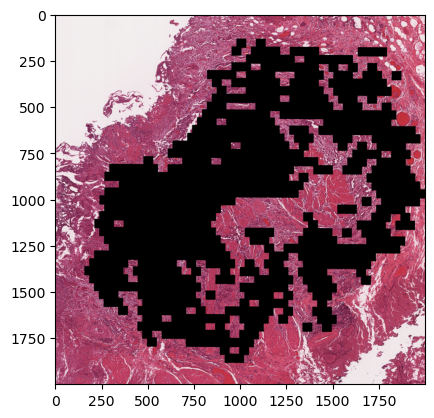

In [5]:
# Set the patch size
patch_size=400

# spatial coordinates of spots
pixel_x=gene_adata.obs["pixel_x"].tolist()
pixel_y=gene_adata.obs["pixel_y"].tolist()

# Test the patch size
mph.test_patch_size(img, patch_size, pixel_x, pixel_y, plot_dir)


#### 4.2 Patch split

- patches: a 4D array with a shape of (N, m, m, 3), where N stands for the total number of spots and m denotes the specified patch size

In [7]:
patches=mph.patch_split_for_ST(img=img, patch_size=patch_size, spot_info=gene_adata.obs, x_name="pixel_x", y_name="pixel_y")
# spot information
patch_info=gene_adata.obs 
patch_info["x"]=patch_info["pixel_x"]
patch_info["y"]=patch_info["pixel_y"]

# Save the splitted image patches and its patch_info
patch_info.to_csv(plot_dir+"/results/patch_info.csv")
np.save(plot_dir+"/results/patches.npy", patches)


In [8]:
patches=np.load(plot_dir+"/results/patches.npy")
patch_info=pd.read_csv(plot_dir+"/results/patch_info.csv", header=0, index_col=0)

#### 4.3 Segment each patch into masks

- n_clusters: equals to the number of masks within each patch (default value is 10) 
- refine the initial K-Means clusters by a convolution layer

In [ ]:
# Perform a K-Means clustering to divide the pixels of each image patch into clusters 
# then employ a convolution layer to refine the cluster assignment
mph.step4_Segmentation(plot_dir=plot_dir, n_clusters=10, refine=True, refine_threshold=4) # take around 2h


In [25]:
mph.check_dic_list(plot_dir)

#### 4.4 Match masks across patches

- num_mask_each: the number of masks within each patch (default value is 10)
- mapping_threshold1: max single color channel difference, choose all channels
- mapping_threshold2: max single color channel difference, choose one channel

In [ ]:
# Identify shared clusters across patches based on color distance
num_mask_each=10
mapping_threshold1=30  # max single color channel difference, choose all channels
mapping_threshold2=60  # max single color channel difference, choose one channel
masks, masks_index=mph.step5_Extract_Masks(plot_dir=plot_dir, patch_size=patch_size, num_mask_each=num_mask_each, mapping_threshold1=mapping_threshold1, mapping_threshold2=mapping_threshold2)

# Plot the segmentated masks
mph.step6_Plot_Masks(plot_dir=plot_dir, d0=d0, d1=d1, masks=masks, patch_size=patch_size, mapping_threshold1=mapping_threshold1, mapping_threshold2=mapping_threshold2)


### 5. Extract interpretable image features

#### 5.1 Mask-level image features

In [27]:
num_mask_each=10
mapping_threshold1=30  # max single color channel difference, choose all channels
mapping_threshold2=60 
masks=np.load(plot_dir+"/results/masks_"+str(mapping_threshold1)+"_"+str(mapping_threshold2)+".npy")
with open(plot_dir+"/results/masks_index_"+str(mapping_threshold1)+"_"+str(mapping_threshold2)+".pkl", "rb") as f:
    masks_index = pickle.load(f)


In [ ]:
ret=mph.Extract_Whole_Mask_Features(masks, patch_info)
ret_logged=mph.Selective_Log_Transfer(ret)


In [ ]:
# print(ret_logged.head()) # mask-level image features

In [29]:
# Save the extracted mask-level image features
ret=sc.AnnData(ret.values,obs=patch_info, var=pd.DataFrame({"feature_names":ret.columns.tolist()}))
ret.var.index=ret.var["feature_names"].tolist()
ret_logged=sc.AnnData(ret_logged.values,obs=patch_info, var=pd.DataFrame({"feature_names":ret_logged.columns.tolist()}))
ret_logged.var.index=ret_logged.var["feature_names"].tolist()
ret_logged.write_h5ad(plot_dir+"/results/mask_features_all_logged.h5ad")


#### 5.2 Object-level image features

In [30]:
# Separate the connected components within each mask
mph.step8_CC_Detection_for_ST(plot_dir=plot_dir, patch_info=patch_info, masks_selected=masks, masks_index_selected=masks_index, details=False)

# Summarize image features for connected components by patch
labels=np.load(plot_dir+"/results/cc_no_details.npy")
channels=[i for i in range(labels.shape[0])]
ret=mph.Extract_CC_Features(labels=labels, patch_info=patch_info, channels=channels, min_area=10)
ret_logged=mph.Selective_Log_Transfer(ret)


Extracting CC for mask  0
Extracting CC for mask  1
Extracting CC for mask  2
Extracting CC for mask  3
Extracting CC for mask  4
Extracting CC for mask  5
Doing channel  0
Doing channel  1
Doing channel  2
Doing channel  3
Doing channel  4
Doing channel  5


In [ ]:
# print(ret_logged.head()) # object-level image features

In [31]:
# Save the extracted object-level image features
ret=sc.AnnData(ret.values,obs=patch_info, var=pd.DataFrame({"feature_names":ret.columns.tolist()}))
ret.var.index=ret.var["feature_names"].tolist()
ret_logged=sc.AnnData(ret_logged.values,obs=patch_info, var=pd.DataFrame({"feature_names":ret_logged.columns.tolist()}))
ret_logged.var.index=ret_logged.var["feature_names"].tolist()
ret_logged.write_h5ad(plot_dir+"/results/cc_features_all_logged.h5ad")

# Combine mask-level image features with object-level image features
sub1=sc.read(plot_dir+"/results/mask_features_all_logged.h5ad")
sub2=sc.read(plot_dir+"/results/cc_features_all_logged.h5ad")
img_adata=ad.concat([sub1, sub2], axis=1,join='inner')
img_adata.obs=sub1.obs
del sub1, sub2
img_adata.write_h5ad(plot_dir+"/results/all_features_logged.h5ad")


#### 5.3 Understand masks

- num_samples: the number of samples for each mask visualization

In [32]:
# Summarize the properties of each mask
ret=mph.mask_properity(masks, img, patch_info, d0, d1, center=True)


Combining mask  0
Combining mask  1
Combining mask  2
Combining mask  3
Combining mask  4
Combining mask  5


In [33]:
print(ret) 

   per_contain  per_area           avg_rgb
0        1.000     0.374  [156.  52.  90.]
1        1.000     0.345  [186.  71. 110.]
2        0.988     0.065  [242. 219. 225.]
3        1.000     0.124  [213. 116. 155.]
4        1.000     0.180     [98. 29. 64.]
5        1.000     0.072  [229. 155. 186.]


In [10]:
img_adata=sc.read(plot_dir+"/results/all_features_logged.h5ad")

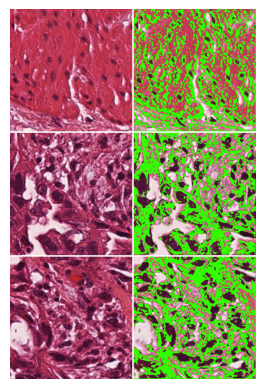

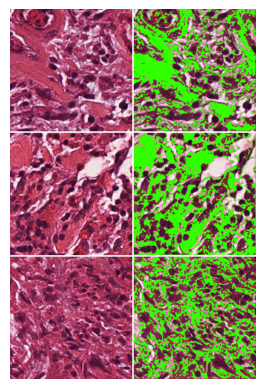

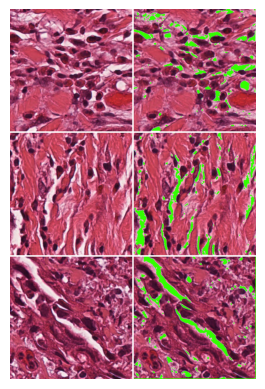

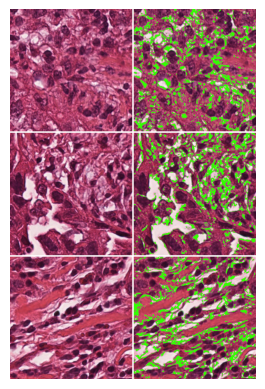

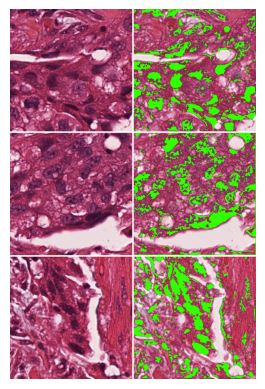

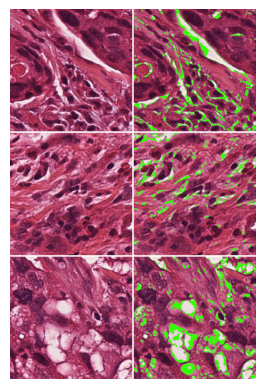

In [35]:
# Plot some sample masks for visuallization
num_samples = 3 # the number of samples for each mask
for channel in range(masks.shape[0]):
    ret_img=mph.mask_example(channel, img_adata, patch_info, patches, masks, plot_dir=plot_dir+"/figures", num_samples=num_samples, filter_mask_area=True)
    ret_img_cvt=cv2.cvtColor(ret_img, cv2.COLOR_BGR2RGB)
    plt.imshow(ret_img_cvt)
    plt.axis('off')
    plt.show()
    plt.close()
    

#### 5.4 Find major masks

In [36]:
# Calculate the area proportion of each mask
mask_area_prop={}
for i in range(masks.shape[0]):
    tmp_prop=[]
    for j in range(masks.shape[1]):
        tmp_prop.append(np.round(np.sum(masks[i, j, ...])/(patch_size*patch_size),3))
    print("Mask ", i)
    mask_area_prop["Mask_"+str(i)]=tmp_prop



Mask  0
Mask  1
Mask  2
Mask  3
Mask  4
Mask  5


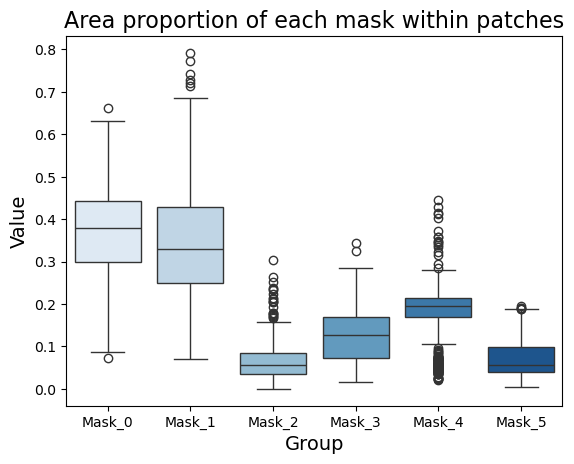

<Figure size 640x480 with 0 Axes>

In [37]:
# Generate box-plots to check mask area proportions
dat_bxplt=pd.DataFrame({
    "Value": [value for values in mask_area_prop.values() for value in values],
    "Group": [group for group, values in mask_area_prop.items() for _ in values]})

sns.boxplot(x="Group", y="Value", data=dat_bxplt, palette="Blues")
plt.title("Area proportion of each mask within patches", fontsize=16)
plt.xlabel("Group", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.savefig(plot_dir+"/figures/mask_area_proportion_boxplot.png", dpi=300)
plt.show()
plt.close()
plt.clf()


From the box-plots, we can find that Mask 0 and Mask 1 capture the most dominant tissue structures.

### 6. Link image features with gene expression
- If users prefer to skip the image extraction and directly proceed with linkage analysis, the pre-generated image features are made available in the [results folder](https://github.com/jianhuupenn/MorphLink/blob/main/tutorial/results). 

#### 6.1 Preprocessing

In [6]:
# Gene expression
gene_adata=sc.read("./toy_data/exp_tumor.h5ad")
gene_adata.X=(np.array(gene_adata.X.A) if issparse(gene_adata.X) else np.array(gene_adata.X))
sc.pp.log1p(gene_adata)

# Histology image
img_adata=sc.read(plot_dir+"/results/all_features_logged.h5ad")
img_adata.X=(img_adata.X.A if issparse(img_adata.X) else img_adata.X)
img_adata=img_adata[img_adata.obs.index.isin(gene_adata.obs.index)]
# Keep image features with over 10% non median 
img_adata=img_adata[:, np.sum(img_adata.X!=np.median(img_adata.X, 0), 0)>(img_adata.shape[0]/10)]


#### 6.2 Spatial clustering on gene expression and image features separately

- To note, **subregion partitioning is optional when pathologists annotations are available**, as region separation by pathologists tends to be more biologically significant and clinically relevant.
<br>
- Here, we perform spatial clustering on gene expression and image features separately to identify subregions where two modalities share spatial pattern similarity.
<br>
- Apart from louvain clustering, other spatial clustering methods (e.g., SpaGCN) can also be employed

In [7]:
# Set colors
cnt_color = clr.LinearSegmentedColormap.from_list('pink_green', ['#3AB370',"#EAE7CC","#FD1593"], N=256)
cat_color=["#F56867","#FEB915","#C798EE","#59BE86","#7495D3","#D1D1D1","#6D1A9C","#15821E","#3A84E6","#997273","#787878","#DB4C6C","#9E7A7A","#554236","#AF5F3C","#93796C","#F9BD3F","#DAB370","#877F6C","#268785"]


In [8]:
# Gene expression
# Louvain clustering (optional step if pathologists annotations are available)
gene_adata=mph.louvain_clustering(input_adata=gene_adata, pca_num=50, n_neighbors=10, resolution=0.1, pred_key="gene_pred")
# or by SpaGCN
gene_adata.obs["gene_pred"]=gene_adata.obs["spagcn_pred"].astype('category') # use the spatial clustering results from SpaGCN


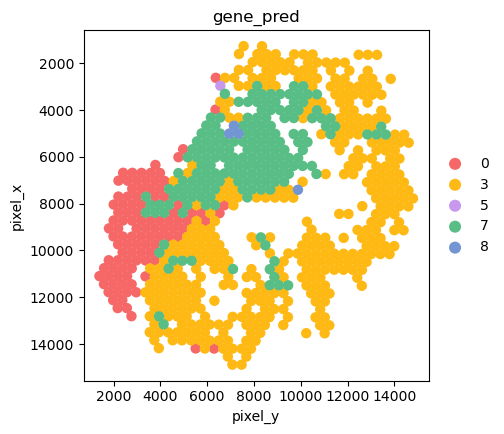

<Figure size 640x480 with 0 Axes>

In [9]:
# Check spatial clustering of gene expression
domains="gene_pred"
num_domains=len(gene_adata.obs[domains].unique())
gene_adata.uns[domains+"_colors"]=list(cat_color[:num_domains])

mph.cat_figure(input_adata=gene_adata, x_col="pixel_y", y_col="pixel_x", color_key=domains, color_map=cat_color, plot_dir=plot_dir)


In [10]:
# Image features 
# Louvain clustering (optional step if pathologists annotations are available)
img_adata=mph.louvain_clustering(input_adata=img_adata, pca_num=50, n_neighbors=10, resolution=0.05, pred_key="img_pred")


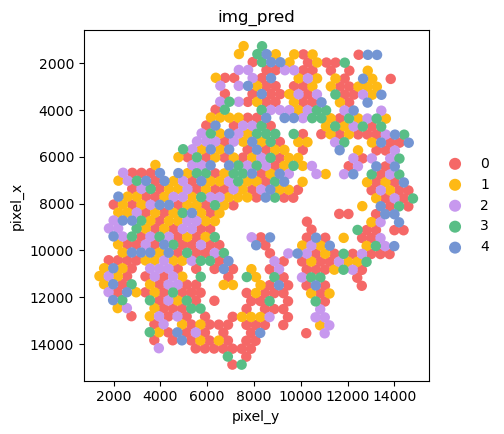

<Figure size 640x480 with 0 Axes>

In [11]:
# Check spatial clustering of image features
domains="img_pred"
num_domains=len(img_adata.obs[domains].unique())
img_adata.uns[domains+"_colors"]=list(cat_color[:num_domains])

mph.cat_figure(input_adata=img_adata, x_col="pixel_y", y_col="pixel_x", color_key=domains, color_map=cat_color, plot_dir=plot_dir)


#### 6.3 Identify subregions

In [23]:
# Check spatial clustering of combined clusters
gene_clusters=gene_adata.obs["gene_pred"].tolist()
img_clusters=img_adata.obs["img_pred"].tolist()

# for any cluster pair if the overlapping spots / overall spots > max_threshod (default value is 0.2) then merge the two clusters
gene_adata.obs["combined_pred"]=mph.combine_clusters(gene_clusters, img_clusters, min_threshold=1/5, max_threshold=1/2)
gene_adata.obs["combined_pred"]=gene_adata.obs["combined_pred"].astype('category')
# ax=spg.plot_spatial_domains_ez_mode(gene_adata, domain_name="combined_pred", x_name="pixel_y", y_name="pixel_x", plot_color=cat_color,size=150000/gene_adata.shape[0], show=False, save=True,save_dir=plot_dir+"/figures/combined.png")


In [43]:
gene_adata.obs["combined_pred"].value_counts(normalize=True)


combined_pred
0.0    0.998496
2.0    0.001504
Name: proportion, dtype: float64

Since over 99% spots belong to one single cluster, no subregion division is needed in this toy dataset.   

In [ ]:
# Plot subregion
# domains="combined_pred"
# num_domains=len(gene_adata.obs[domains].unique())
# gene_adata.uns[domains+"_colors"]=list(cat_color[:num_domains])
# ax=sc.pl.scatter(gene_adata,alpha=1,x="pixel_y",y="pixel_x",color=domains,title=domains,color_map=cat_color,show=False,size=150000/img_adata.shape[0])
# ax.set_aspect('equal', 'box')
# ax.axes.invert_yaxis()
# plt.savefig(plot_dir+"/figures/combined_pred.png", dpi=300)
# plt.show()
# plt.close()
# plt.clf()


#### 6.4 Quantify the curve-based similarity

- genes: a set of interested genes or identified from DE analysis
- channel: the mask channel number to focus on
- w_cor: the weights for correlation (default value is 0.5)
- CPSI: Curve-based Pattern Similarity Index

In [12]:
# Specify a set of genes (or from DE analysis) that are related to the interested biological process
# e.g., a set of genes related to antigen presentation
genes_set=['HLA-F', 'HHLA3', 'HLA-DR', 'CD1D', 'IFNG', 'LMP7', 'VCAM1', 'RFXANK', 'ERAP2', 'CD274', 'PDCD1', 'LMP2', 'TAPBPL', 'HLA-DQ', 'HLA-DP', 'ERAP1', 'HLA-DMA', 'CD40', 'IDO1', 'IFI16', 'HLA-E', 'HLA-DMB', 'RFX5', 'AP1M1', 'TAP2', 'TAP1', 'HHLA2', 'LMP10', 'CD80', 'PSMB8', 'CALR', 'CD74', 'HHLA1', 'RFXAP', 'CD86', 'CD70', 'CIITA', 'CTLA4', 'TAPBP', 'PSMB10', 'MR1', 'PSMB9', 'NLRC5', 'HLA-G', 'ICOS', 'CD40LG', 'SEC61', 'IRF1', 'CD276', 'ICAM1', 'B2M']
filtered_genes_set=list(set(genes_set) & set(gene_adata.var.index.tolist()))

# Calculate the spatial similarity between generated image features and selected genes set by CPSI
channel=4 # specify the target mask channel
CPSI=mph.cpsi_eva(gene_adata, img_adata, filtered_genes_set, channel)



       log_m4_Area_of_1  log_m4_Area_of_1_ratio  log_m4_Dist_Trans_0_mean  \
HHLA3          0.204665                0.194191                  0.110826   
VCAM1          0.200720                0.256657                  0.202183   
RFX5           0.238212                0.158967                  0.011787   
CD1D           0.075035                0.014613                  0.044538   
IFI16          0.279825                0.260272                  0.130050   

       log_m4_Dist_Trans_0_std  log_m4_Dist_Trans_1_mean  \
HHLA3                 0.104524                  0.376204   
VCAM1                 0.142377                  0.432090   
RFX5                  0.053329                  0.300530   
CD1D                  0.099540                  0.558269   
IFI16                 0.105412                  0.364348   

       log_m4_Dist_Trans_1_median  log_m4_Dist_Trans_1_std  \
HHLA3                    0.358620                 0.395268   
VCAM1                    0.396921                 0.

#### 6.5 Generate marginal curves

In [13]:
# e.g., gene CD74
g="CD74"

# Identify the image feature that has the highest CPSI with the target gene and generate a gradient marginal curve along x-axis and y-axis for the target pair of gene expression and image feature
range_step=1/4
num_cuts=5
f, x, y, _=mph.marginal_curve(gene_adata, img_adata, CPSI, g, range_step, num_cuts)
print("Image feature of "+f+" has the highest CPSI with the target gene "+g)


The identified image feature having the highest CPSI with the target gene CD74: c4_solidity_iqr
Image feature of c4_solidity_iqr has the highest CPSI with the target gene CD74


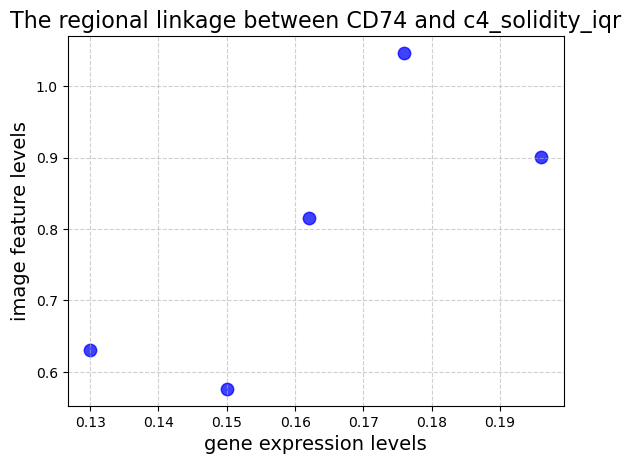

<Figure size 640x480 with 0 Axes>

In [30]:
# Generate a scatter plot for x and y
plt.scatter(x, y, s=80, c='blue', alpha=0.75)
plt.xlabel("gene expression levels", fontsize=14)
plt.ylabel("image feature levels", fontsize=14)
plt.title("The regional linkage between "+g+" and "+f, fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig(plot_dir+"/figures/scatterplot_"+g+"_"+f+".png", dpi=300)
plt.show()
plt.close()
plt.clf()


#### 6.6 Statistical test to evaluate the confidence of the selected image feature

In [14]:
# perform a two-sample one-sided t-test
target_f_scores=CPSI.loc[:,f].values.flatten()
other_f_scores=CPSI.loc[:,CPSI.columns!=f].values.flatten()
scipy.stats.ttest_ind(target_f_scores, other_f_scores,alternative="greater")


TtestResult(statistic=13.479564019470327, pvalue=6.229441882447931e-41, df=4520.0)

p-value is smaller than 0.05, indicating that the selected image feature has significantly higher CPSIs with the target set of genes compared to other image features.

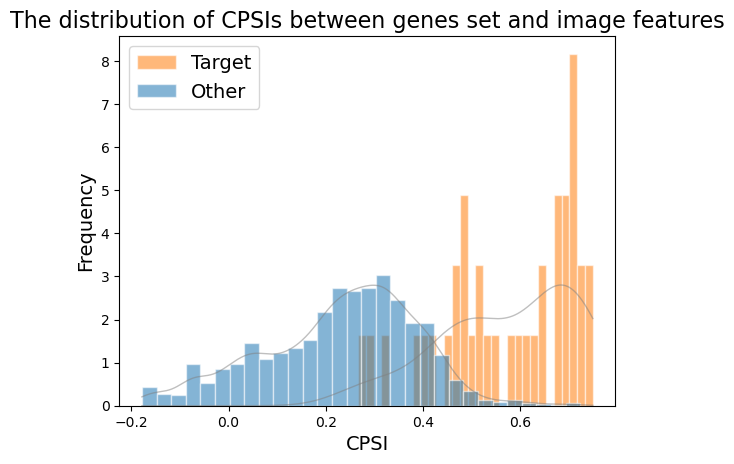

<Figure size 640x480 with 0 Axes>

In [16]:
# Generate a histogram to check CPSIs distribution
mph.cpsi_distri_histo(target_f_scores=target_f_scores, other_f_scores=other_f_scores)


### 7. Select samples for visual demonstration

- num_sample: the number of samples for demonstrating the linkage between the pair of gene expression feature and image feature

In [17]:
labels=np.load(plot_dir+"/results/cc_no_details.npy")

In [ ]:
# Load in the generated patch_info, patches, and labels
plot_dir="."
patch_info=pd.read_csv(plot_dir+"/results/patch_info.csv", header=0, index_col=0)
patches=np.load(plot_dir+"/results/patches.npy")
labels=np.load(plot_dir+"/results/cc_no_details.npy")

# Specify a set of interested image features
target_features = [f]
visual_img_list = []
num_sample=5
print(target_features)

for f in target_features:
    if not os.path.exists(plot_dir+"/figures/"+f):
        os.mkdir(plot_dir+"/figures/"+f)
    visual_img=mph.sample_illustration(f, img_adata, patch_info, patches, labels, plot_dir=plot_dir+"/figures/"+f, num_cuts=num_cuts, range_step=range_step, num_sample=num_sample, filter_mask_area=True, filter_cc_q100=False)
    visual_img_list.append(visual_img)



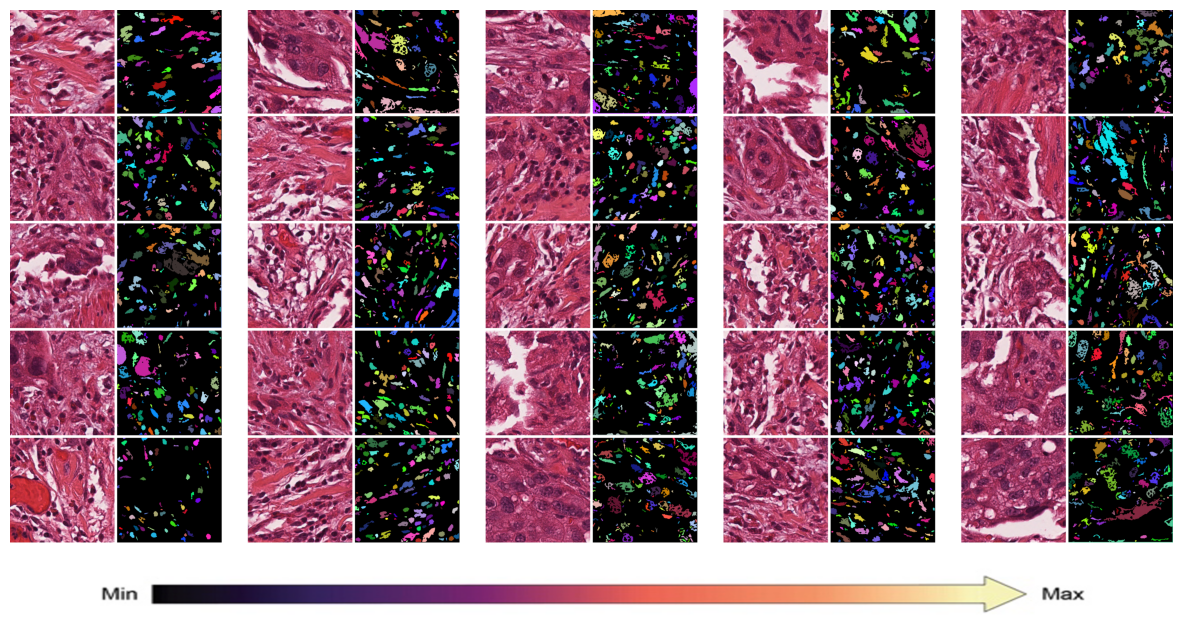

<Figure size 640x480 with 0 Axes>

In [19]:
# Read in arrow image 
arrow_img=cv2.imread(plot_dir+"/figures/arrow.png", cv2.IMREAD_UNCHANGED)
arrow_img=cv2.cvtColor(arrow_img, cv2.COLOR_BGR2RGB) # convert BGR to RGB (already a numpy array)

# Generate sample linkage visual demonstration
mph.sample_linkage_visualization(visual_img_list=visual_img_list, target_features=target_features, arrow_img=arrow_img, plot_dir=plot_dir)


### 8. Parameter settings

Patch segmentation: k, t, &alpha;.
- k: the number of initial clusters (default value is 10 and recommend using the default).
- t: the threshold used to control the integrity of clusters for spatial smoothing (default value is 4 and recommend using the default).
- &alpha;: the threshold used to control color distances in cluster merging (default value is 30, and it can be set to 20 for thinner structures).

Mask matching: &alpha;.
- &alpha;: same as above.

Subregion devision: &beta;.
- &beta;: Jaccard index to evaluate the overlapping between cluster pairs (default value is 0.2 and recommend using the default).

Calculating marginal curves: l.
- l: the parameter of window size used to control the number of intervals within a subregion (default value is 100, and it can be set to 50 for capturing coarse marginal patterns).